# Coursera Course Analysis

Understanding learner demand across difficulty levels, certificate types, and institutions

## Executive Summary

This analysis of Coursera courses highlights clear learner trends:

- **Beginner-focused**: Most enrollments go to beginner and mixed level courses.
- **Tech & Data dominate**: They dominate enrollents across the platform.
- **Career-driven**: Professional certificates, though few, attract demand.
- **Trusted names matter**: A handful of universities account for half of enrollements.
- **Not pure 80/20** Top 20% of courses drive ~65% of enrollments.

## Dataset Overview

The dataset includes ~900 courses with the following fields:
- course_title: Title of the course.
- course_organizations: Organization/university offering the course
- course_Certificate_type: Course format (Course, Specilization, Professional Certificate)
- course_rating: Average learner rating (out of 5)
- course_difficulty: Difficulty level (Beginner, Intermediate, Advanced, Mixed)
- course_students_enrolled: Number of enrolled learners.

This dataset enables analysis from two complementary perspectives:
- **Perceived quality** - using course rating to understand learner satisfaction
- **Popularity** - using enrollments as a proxy for demand

By combining these dimensions, the analysis explores whether highly rated courses also attract the most learners, and how factors such as difficulty level, certificate type, and institution influence enrollment patterns.


### Imports

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load Dataset

- **Source:** Kaggle  
- **Dataset:** Coursera Course Dataset  
- **Link:** https://www.kaggle.com/datasets/siddharthm1698/coursera-course-dataset

**Setup:**  
Download the dataset from Kaggle, extract the CSV file, and place it in the `data/` directory.

In [7]:
DATA_PATH = os.path.join("data", "coursea_data.csv")
df = pd.read_csv(DATA_PATH)

print("Loaded:", DATA_PATH)
print("Shape:", df.shape)

Loaded: data/coursea_data.csv
Shape: (891, 7)


### Data Preparation Utilities

The following helper functions encapsulates the data cleaning and preparation logic used throughout the analysis to keep the main workflow readable.

In [13]:
def sanity_check(df):
    print("\nMissing values per column:")
    print(df.isna().sum())

    print("\nDuplicate rows:", df.duplicated().sum())
    if "course_title" in df.columns:
        print("Duplicate course titles:", df["course_title"].duplicated().sum())

    if "course_rating" in df.columns:
        print("\nRating outside 0-5:")
        print(df.query("course_rating < 0 or course_rating > 5"))

    if "course_students_enrolled" in df.columns:
        print("\nNegative enrollments:")
        print(df.query("course_students_enrolled < 0"))

    return df

In [14]:
def clean_df(df):
    import pandas as pd
    import numpy as np

    # drop old index column
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])

    # changing dType to int64 and also turing k into 1000
    def parse_enrolled(raw_value):
        # Handle missing values
        if pd.isna(raw_value):
            return np.nan

        # Clean string
        raw_value = str(raw_value).lower().replace(",", "").strip()

        # Handling suffix
        if raw_value.endswith("k"):
            return int(float(raw_value[:-1]) * 1000)

        elif raw_value.endswith("m"):
            return int(float(raw_value[:-1])* 1000000)

        else:
            return int(float(raw_value))    # plain number

    # Apply the parser row by row
    if "course_students_enrolled" in df.columns:
        df["course_students_enrolled"] = (
            df["course_students_enrolled"].apply(parse_enrolled).astype("int64")
        )
    # Convert to categories

    if "course_organization" in df.columns:
        df["course_organization"] = df["course_organization"].astype("category")

    if "course_Certificate_type" in df.columns:
        df["course_Certificate_type"] = df["course_Certificate_type"].astype("category")

    if "course_difficulty" in df.columns:
        levels = ["Beginner", "Intermediate", "Advanced", "Mixed"]
        df["course_difficulty"] = pd.Categorical(
            df["course_difficulty"], categories=levels, ordered=True
            )
    return df

### Cleaning and Sanity Check

In [17]:
df = clean_df(df)
df = sanity_check(df)


Missing values per column:
course_title                0
course_organization         0
course_Certificate_type     0
course_rating               0
course_difficulty           0
course_students_enrolled    0
dtype: int64

Duplicate rows: 0
Duplicate course titles: 3

Rating outside 0-5:
Empty DataFrame
Columns: [course_title, course_organization, course_Certificate_type, course_rating, course_difficulty, course_students_enrolled]
Index: []

Negative enrollments:
Empty DataFrame
Columns: [course_title, course_organization, course_Certificate_type, course_rating, course_difficulty, course_students_enrolled]
Index: []


Three course titles appear more than once in the dataset.  
The following section investigates whether these are true duplicates or legitimate variations.

In [20]:
title_counts = df["course_title"].value_counts()
duplicate_titles = title_counts[title_counts > 1]

print("Duplicate course titles (total occurrences):")
print(duplicate_titles)

duplicates_full = df.loc[df["course_title"].isin(duplicate_titles.index)]
display(duplicates_full.sort_values("course_title"))

Duplicate course titles (total occurrences):
course_title
Developing Your Musicianship    2
Marketing Digital               2
Machine Learning                2
Name: count, dtype: int64


,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
224,Developing Your Musicianship,Berklee College of Music,COURSE,4.8,Mixed,41000
225,Developing Your Musicianship,Berklee College of Music,SPECIALIZATION,4.8,Beginner,54000
563,Machine Learning,University of Washington,SPECIALIZATION,4.6,Intermediate,290000
564,Machine Learning,Stanford University,COURSE,4.9,Mixed,3200000
582,Marketing Digital,Universidade de São Paulo,COURSE,4.8,Beginner,81000
583,Marketing Digital,Universidad Austral,SPECIALIZATION,4.7,Beginner,39000


### Duplicate Title Assessment

Three course titles appear more than once in the dataset.

On closer inspection, these entries are not exact duplicates.  
Although the course titles are the same, the records differ by:
- offering institution
- certificate type (Course vs Specialization)
- difficulty level
- number of enrolled students

This suggests that these are **legitimate variations of courses sharing the same name**, rather than data quality issues.

**Decision:**  
All records were retained in the dataset.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   course_title              891 non-null    object  
 1   course_organization       891 non-null    category
 2   course_Certificate_type   891 non-null    category
 3   course_rating             891 non-null    float64 
 4   course_difficulty         891 non-null    category
 5   course_students_enrolled  891 non-null    int64   
dtypes: category(3), float64(1), int64(1), object(1)
memory usage: 30.1+ KB


## Analysis

### Course Ratings

Insight: Ratings are consistently high (most > 4.5)

Most Coursera courses have very high ratings, suggesting that learners are generally satisfied. However, ratings alone do not explain popularity, as enrollments vary widely across courses.

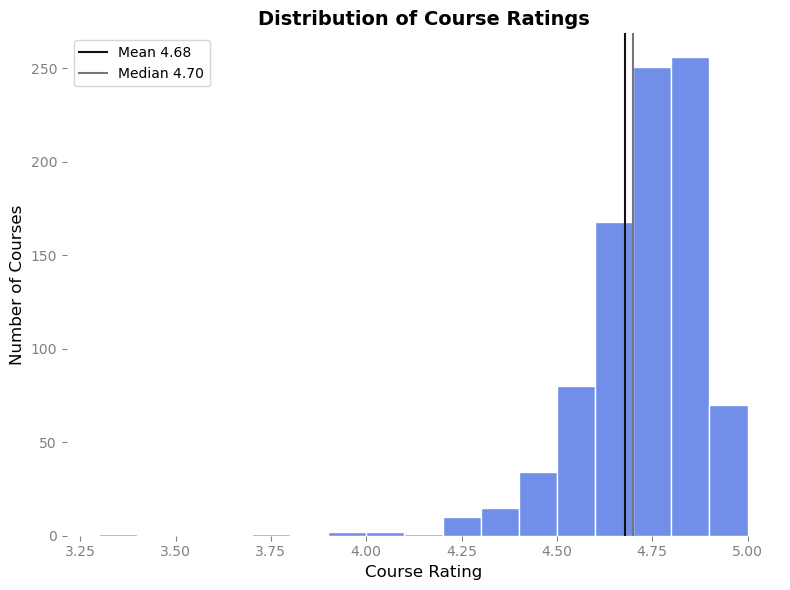

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# stats
mean = df["course_rating"].mean()
median = df["course_rating"].median()

# plot
plt.figure(figsize=(8,6))
ax = sns.histplot(df["course_rating"],
                  bins=17, color="royalblue", edgecolor="white")

# titles and labels
ax.axvline(mean, color="#111", linestyle="-",
           linewidth=1.5, label=f"Mean {mean:.2f}")
ax.axvline(median, color="#777", linestyle="-",
           linewidth=1.5, label=f"Median {median:.2f}")

ax.set_title("Distribution of Course Ratings", fontsize=14, weight="bold")
ax.set_xlabel("Course Rating", fontsize=12)
ax.set_ylabel("Number of Courses", fontsize=12)

# cleaning
sns.despine()
for spine in ["left", "bottom"]:
    ax.spines[spine].set_color("grey")
    ax.spines[spine].set_alpha(0)
ax.tick_params(axis="x", colors="grey")
ax.tick_params(axis="y", colors="grey")

plt.tight_layout()
ax.legend()
plt.show()

### Distribution of Enrollments

Insight: Enrollments are highly skewed: a small number of courses reach millions, while most remain under 100k. We can see in the long tail distribution below.

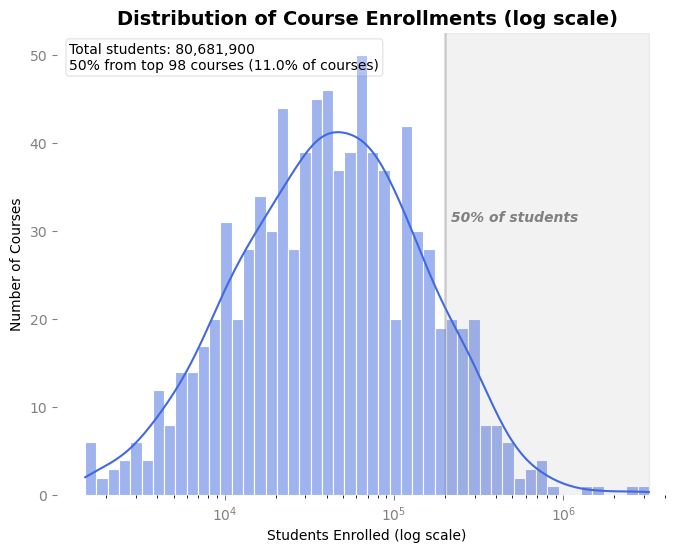

In [25]:
# calculating 50% dominance by enrollment
enrolled_sorted = df["course_students_enrolled"].sort_values(ascending=False)
total_enrolled = enrolled_sorted.sum()
cum_share = enrolled_sorted.cumsum() / total_enrolled
cutoff_share = (cum_share <= 0.5).sum()
cutoff_percent = cutoff_share / len(enrolled_sorted) * 100
x_line = enrolled_sorted.iloc[cutoff_share]

# Plot
plt.figure(figsize=(8,6))
ax = sns.histplot(
    df["course_students_enrolled"],
    bins=50, log_scale=True, kde=True, color="royalblue", edgecolor="white"
)

# vertical line (x_line) and shading at 50% cutoff
ax.axvline(x_line, color="grey", linestyle="-", linewidth=1.8, alpha = 0.3)
ax.axvspan(x_line, df["course_students_enrolled"].max(),
           color="grey", alpha=0.1)

# Print headline numbers
msg = (f"Total students: {total_enrolled:,}\n"
       f"50% from top {cutoff_share} courses "
       f"({cutoff_percent:.1f}% of courses)")
ax.text(
    0.02, 0.98, msg,
    transform=ax.transAxes,
    va="top", ha="left",
    fontsize=10, bbox=dict(boxstyle="round,pad=0.25",
                           facecolor="white",
                           edgecolor="grey",
                           alpha=0.2)
)

# titles and labels
ax.set_title("Distribution of Course Enrollments (log scale)",
             fontsize=14, weight="bold")
ax.set_xlabel("Students Enrolled (log scale)")
ax.set_ylabel("Number of Courses")
ax.text(
    0.84, 0.6, "50% of students",
    transform=ax.transAxes,
    va="center", ha="right",
    fontsize=10, fontweight="bold", style="italic", color="grey"
)

# cleaning chart
sns.despine()
for spine in ["left", "bottom"]:
    ax.spines[spine].set_color("grey")
    ax.spines[spine].set_alpha(0)
    ax.tick_params(axis="x", colors="grey")
    ax.tick_params(axis="y", colors="grey")

plt.show()

Interpretation:

Course enrollments follow a highly unequal distribution.
Approximately half of all learners are concentrated in just 11% of courses, indication strong winner takes most dynamics on the platform.

### Enrollments by Difficulty
Insight: Beginner and mixed-level courses account for the majority of enrollments. Coursera is clearly strongest as a platform for **beginner-level learners**. Advanced courses enrol fewer students, which can affect progression for learners.

- Beginner level courses dominate by supply.
- Mixed level courses dominate by demand, as learners may prefer flexibility, possibly because its a safe choice when skill levels are uncertain at entry.

/var/folders/6q/l9kghf9s5b3ft4g5894t4kkm0000gn/T/ipykernel_60314/3245616138.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("course_difficulty")["course_students_enrolled"]


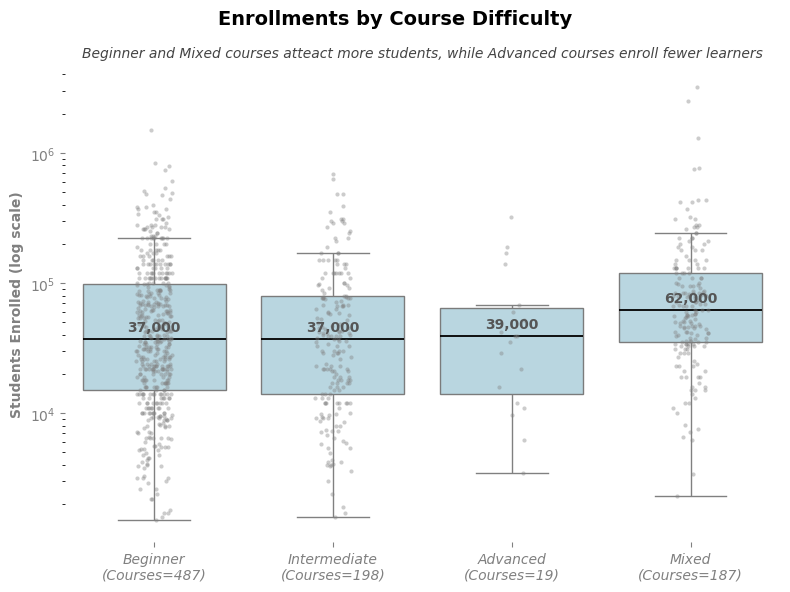

In [26]:
# order
levels = ["Beginner", "Intermediate", "Advanced", "Mixed"]

# stats
medians = (
    df.groupby("course_difficulty")["course_students_enrolled"]
    .median()
)

counts = (
    df["course_difficulty"]
    .value_counts()
    .astype(int)
)

# plot
plt.figure(figsize=(8,6))
ax = sns.boxplot(
    data=df,
    x="course_difficulty",
    y="course_students_enrolled",
    color="#b3d9e6",
    medianprops=dict(color="black", linewidth=1.3),
    whiskerprops=dict(color="grey", linewidth=1),
    capprops=dict(color="grey", linewidth=1),
    order=levels,
    showfliers=False
)

# jittered points
sns.stripplot(
    data=df,
    x="course_difficulty",
    y="course_students_enrolled",
    order=levels,
    color="grey",
    alpha=0.4,
    jitter=True,
    size=3
)

# median labels inside boxes
for box_number, (cat, val) in enumerate(medians.items()):
    ax.text(
        x=box_number,
        y=val * 1.1,      # 1.1 = a bit higher that the median
        s=f"{int(val):,}",
        ha="center", va="bottom",
        color="#555", fontsize=10, weight="bold",
)

# log scale
ax.set_yscale("log")

# tick labels with counts
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(
    [f"{cat}\n(Courses={counts.get(cat)})" for cat in levels],
    color="#444", fontsize=10, fontstyle="italic"
)

# titles, labels
plt.suptitle("Enrollments by Course Difficulty", fontsize=14, weight="bold")
ax.set_title("Beginner and Mixed courses atteact more students, while Advanced courses enroll fewer learners",
             fontsize=10, color="#444", style="italic")
ax.set_xlabel(None)
ax.set_ylabel("Students Enrolled (log scale)", color="grey", weight="bold")


# cleaning chart
sns.despine()
for spine in ["left", "bottom"]:
    ax.spines[spine].set_color("grey")
    ax.spines[spine].set_alpha(0)
ax.tick_params(axis="x", colors="grey")
ax.tick_params(axis="y", colors="grey")

plt.tight_layout()
plt.show()

### Enrollment by Certificate Type
Insights: Professional Certificates show the highest median enrollments despite a very limited number of courses, indicating a potential supply gap for Coursera to explore.

Career focused learners engage strongly, but Coursera has not yet scaled supply in this category.

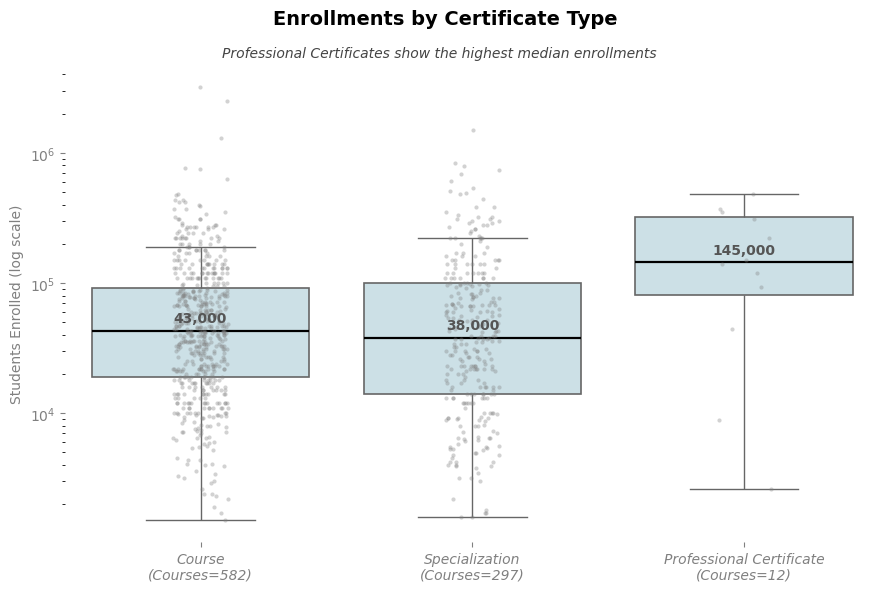

In [28]:
# order
cert_levels = ["COURSE", "SPECIALIZATION", "PROFESSIONAL CERTIFICATE"]

# stats
median_cert = (
    df.groupby("course_Certificate_type", observed=False)["course_students_enrolled"]
    .median()
    .reindex(cert_levels)
)

count_cert = (
    df["course_Certificate_type"]
    .value_counts()
    .astype(int)
    .reindex(cert_levels)
)

# plot

plt.figure(figsize=(9,6))
ax = sns.boxplot(
    data=df,
    x="course_Certificate_type",
    y="course_students_enrolled",
    order=cert_levels,
    color= "#C7E2EB",
    fliersize=0,
    linewidth=1.2,
    boxprops=dict(edgecolor="#666666"),
    medianprops=dict(color="black", linewidth=1.6),
    whiskerprops=dict(color="#666666", linewidth=1),
    capprops=dict(color="#666666", linewidth=1),
)

# jittered points
sns.stripplot(
    data=df,
    x="course_Certificate_type",
    y="course_students_enrolled",
    order=cert_levels,
    color="grey",
    alpha=0.35,
    jitter=True,
    size=3,
)

# median labels inside boxes
for box_number, (cat, val) in enumerate(median_cert.items()):         #enumerate when i need one column
    ax.text(
        x=box_number,
        y=val * 1.1,      # 1.1 = a bit higher that the median
        s=f"{int(val):,}",
        ha="center", va="bottom",
        color="#555", fontsize=10, weight="bold",
)

# labels
ax.set_yscale("log")
ax.set_ylabel("Students Enrolled (log scale)", color="grey")
ax.set_xlabel(None)
ax.set_xticks(range(len(cert_levels)))
ax.set_xticklabels(
    [f"{cat.title()}\n(Courses={count_cert.get(cat,0)})" for cat in cert_levels],
    color="#444444", fontsize=10, fontstyle="italic"
)

# titles
plt.suptitle("Enrollments by Certificate Type",
             fontsize=14, fontweight="bold", y=0.98)
ax.set_title("Professional Certificates show the highest median enrollments",
             fontsize=10, color="#444", style="italic", x=0.46)

# cleaning
sns.despine()
for spine in ["left", "bottom"]:
    ax.spines[spine].set_color("grey")
    ax.spines[spine].set_alpha(0)
ax.tick_params(axis="x", colors="grey")
ax.tick_params(axis="y", colors="grey")

plt.tight_layout()
plt.show()

### Top 10 Organizations by Enrollments

Insight: Enrollment is highly concentrated. The top 10 organizations alone account for 53% of total enrollments, indicating strong institutional dominance.

Observation: Traditional universities continue to outperfrom corporate providers in total learner reach.


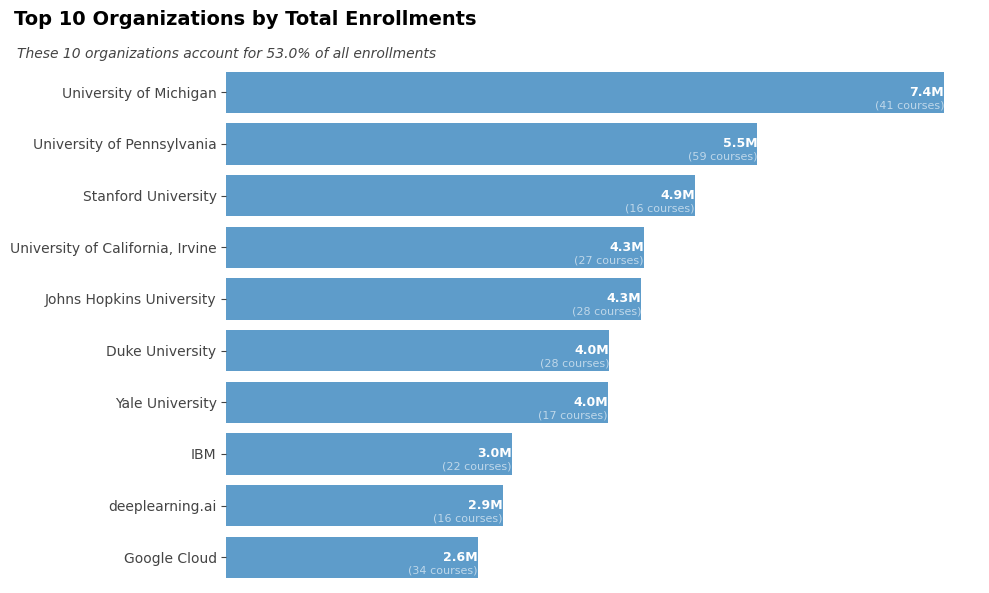

In [29]:
# stats
org_stats_top10 = (
    df.groupby("course_organization", observed=False)["course_students_enrolled"]
    .agg(total_enrolled="sum", total_courses="count")
    .sort_values("total_enrolled", ascending=False)
    .head(10)
    .reset_index()
)
grand_total = df["course_students_enrolled"].sum()
top10_total = org_stats_top10["total_enrolled"].sum()
share = top10_total / grand_total * 100

# create a list of top 10 orgs in the right order
order=org_stats_top10["course_organization"].tolist()

# plot
plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=org_stats_top10,
    x="total_enrolled",
    y="course_organization",
    order=order,
    color="#4C9FDC"
)

# bar labels
for position, row in org_stats_top10.iterrows():      #iterrows when you need several columns at once
    total = row["total_enrolled"]
    courses = row["total_courses"]
    millions = round(total / 1000000, 1)

    # Bold numbers
    ax.text(
        x=total, y=position,
        s=f"{millions}M",
        va="center", ha="right",
        color="white", fontsize=9, weight="bold")

    # smaller number
    ax.text(
        x=total, y=position + 0.25,
        s=f"({courses} courses)",
        va="center", ha="right",
        color="white", fontsize=8, alpha=0.6)


# titles
plt.suptitle("Top 10 Organizations by Total Enrollments",
             fontsize=14, weight="bold", x=0.25)
ax.set_title(f"These 10 organizations account for {share:.1f}% of all enrollments",
             fontsize=10, color="#444", style="italic", pad=6, x=0.0)

# cleaning
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_xticks([])
ax.set_xticklabels([])
sns.despine()
for spine in ["left", "bottom"]:
    ax.spines[spine].set_color("grey")
    ax.spines[spine].set_alpha(0)
ax.tick_params(axis="y", colors="#444", labelsize=10)

plt.tight_layout()
plt.show()

### Top 15 Courses by Enrollments
The most popular courses are dominated by **Data & Tech** with **The Science of Well-Being** as an outlier.

While Technical skills drive demand and data skills function as a global currency, a small number of human-skills courses also break into the top rankings.

/var/folders/6q/l9kghf9s5b3ft4g5894t4kkm0000gn/T/ipykernel_60314/2589044040.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


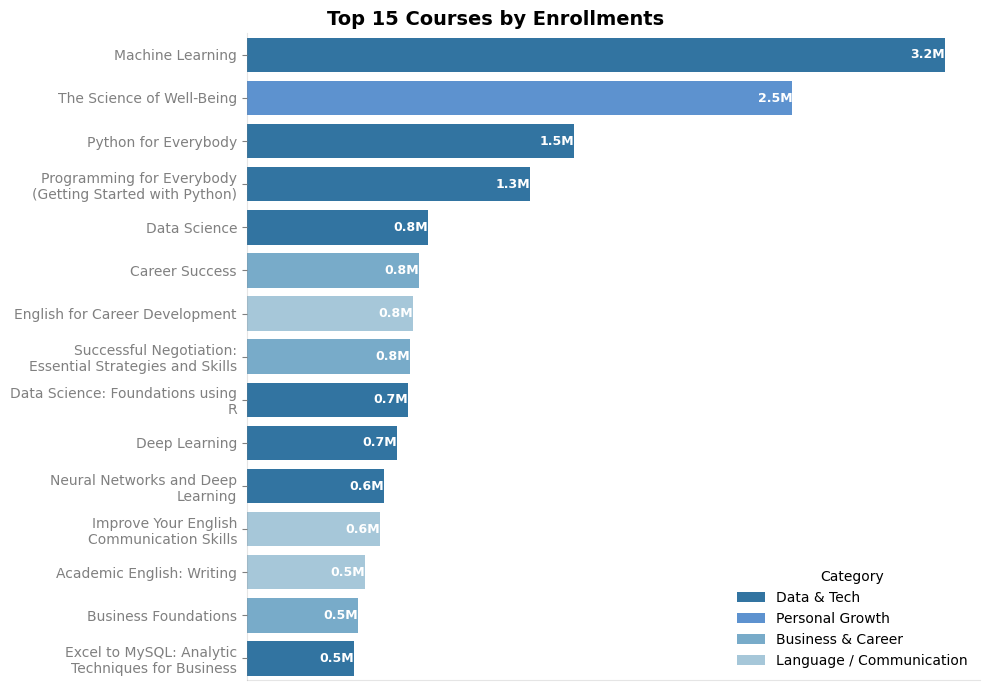

In [30]:
import textwrap
# stats
top_courses = (
    df[["course_title", "course_students_enrolled"]]
    .sort_values("course_students_enrolled", ascending=False)
    .head(15)
)

# mapping: course to bucket
bucket = {
    "Machine Learning": "Data & Tech",
    "The Science of Well-Being": "Personal Growth",
    "Python for Everybody": "Data & Tech",
    "Programming for Everybody (Getting Started with Python)": "Data & Tech",
    "Data Science": "Data & Tech",
    "Career Success": "Business & Career",
    "English for Career Development": "Language / Communication",
    "Successful Negotiation: Essential Strategies and Skills": "Business & Career",
    "Data Science: Foundations using R": "Data & Tech",
    "Deep Learning": "Data & Tech",
    "Neural Networks and Deep Learning": "Data & Tech",
    "Improve Your English Communication Skills": "Language / Communication",
    "Academic English: Writing": "Language / Communication",
    "Business Foundations": "Business & Career",
    "Excel to MySQL: Analytic Techniques for Business": "Data & Tech",
}

top_courses["bucket"] = top_courses["course_title"].map(bucket).fillna("Other")

# color
bucket_palette = {
    "Data & Tech": "#1f77b4",
    "Personal Growth": "#4a90e2",
    "Business & Career": "#6baed6",
    "Language / Communication": "#9ecae1"
}

# plot
plt.figure(figsize=(10,7))
ax = sns.barplot(
    data=top_courses,
    x="course_students_enrolled",
    y="course_title",
    hue="bucket",
    dodge=False,
    palette=bucket_palette

)

for position, value in enumerate(top_courses["course_students_enrolled"]):
    millions = round(value / 1000000, 1)
    ax.text(
        x=value, y=position,
        s=f"{millions}M",
        va="center", ha="right",
        color="white", fontsize=9, weight="bold"
    )

# titles and labels
ax.set_title("Top 15 Courses by Enrollments", fontsize=14, weight="bold", x=0.34),
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_xticks([])
ax.set_yticklabels(
    [textwrap.fill(label.get_text(), 32) for label in ax.get_yticklabels()]
)

# cleaning
sns.despine()
for spine in ["left", "bottom"]:
    ax.spines[spine].set_color("grey")
    ax.spines[spine].set_alpha(0.2)
ax.tick_params(axis="y", colors="grey")

plt.legend(title="Category", loc="lower right", frameon=False)
plt.tight_layout()
plt.show()

### Pareto Analysis of Enrollments
Insight: The top 20% of courses generate approximately 65% of total enrollments. While this is less extreme than a classic 80/20 distribution, Coursera remains highly dependent on a small subset of top-performing courses.

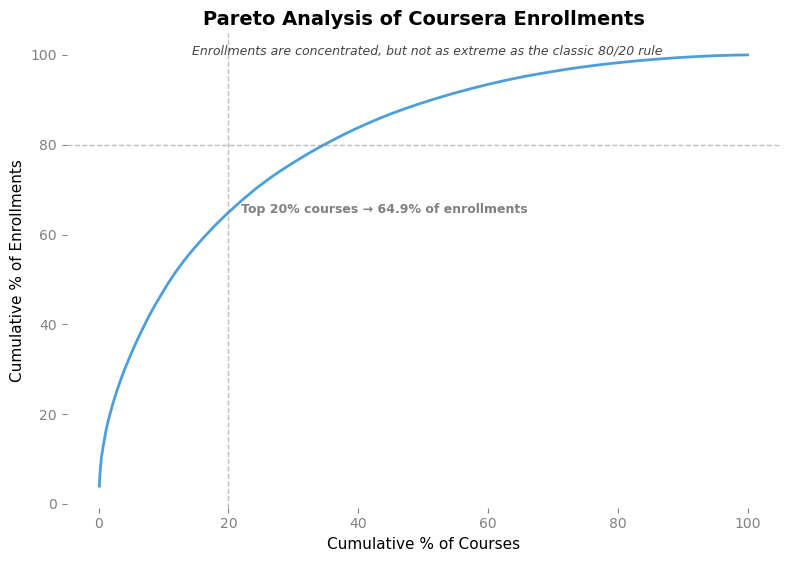

In [32]:
pareto = (
    df[["course_title", "course_students_enrolled"]]
    .sort_values("course_students_enrolled", ascending=False)
    .reset_index(drop=True)
)

total_enrolled = pareto["course_students_enrolled"].sum()

pareto["cum_enrolled"] = pareto["course_students_enrolled"].cumsum()
pareto["cum_share"] = pareto["cum_enrolled"] / total_enrolled * 100
pareto["course_share"] = (pareto.index + 1) / len(pareto) * 100

# find share at 20% of courses
x_20 = pareto["course_share"].iloc[int(len(pareto)*0.2)-1]
y_20 = pareto["cum_share"].iloc[int(len(pareto)*0.2)-1]


plt.figure(figsize=(8,6))
ax = sns.lineplot(
    data=pareto,
    x="course_share",
    y="cum_share",
    color="#4C9FDC",
    linewidth=2
)

# add 80/20 reference lines
ax.axvline(20, color="grey", linestyle="--", linewidth=1, alpha=0.5)
ax.axhline(80, color="grey", linestyle="--", linewidth=1, alpha=0.5)

# add annotation
ax.annotate(
    f"Top 20% courses → {y_20:.1f}% of enrollments",
    xy=(20, y_20), xycoords="data",
    xytext=(22, y_20), textcoords="data",
    fontsize=9, weight="bold", color="grey"
)

# labels
plt.title("Pareto Analysis of Coursera Enrollments", fontsize=14, weight="bold")
plt.suptitle(
    "Enrollments are concentrated, but not as extreme as the classic 80/20 rule",
    fontsize=9, color="#444", style="italic", y=0.87, x=0.54)
ax.set_xlabel("Cumulative % of Courses", fontsize=11)
ax.set_ylabel("Cumulative % of Enrollments", fontsize=11)

sns.despine()
for spine in ["left", "bottom"]:
    ax.spines[spine].set_color("grey")
    ax.spines[spine].set_alpha(0)
ax.tick_params(axis="x", colors="grey")
ax.tick_params(axis="y", colors="grey")

plt.tight_layout()
plt.show()

## Key Takeaways

1. **Most learners start at the beginning** : Courser's strength is clearly in beginner-friendly and mixed-level courses, advanced courses dont see the same demand.  
2. **Data & Tech dominate the platform**: Courses in Data & Tech consistently have larger enrollments, showing where learners interest and likely career demand really is.   
3. **Professional Certificates have a higher demand**: There are few in numbers, but they attract huge enrollments, a clear signal that career oriented credentials are in demand.
4. **Top institutions drive trust**: Just 10 institutions account for more than hald of enrollments, proving the importance of trusted names like Michigan, Stanford and IBM.
5. **A few courses pull the crowd, but many still explore beyond**: About 20% of courses bring in ~65% of all enrollments, concentrated but still broader than the classic 80/20 pareto principle.

Overall, Courseras strength is **a trusted entry point for global learners, especially in Data & Tech**.

## Business Implications

- **Expand Professional Certificates**: Small supply but very high demand.
- **Create clear learner progression paths**: Most people stick to beginner level. Guiding them step by step into intermediate and adanced courses would keep them engaged longer.
- **Double down on Data & Tech**: Its clear this is where learners and employers are most focused. Marketing and partnerships should reflect this demand.
- **Help learners find their level**: Many choose beginner or mixed because they're unsure where they stand. Placement tests could help them into the right course, improving rentention and satisfaction.


## Limitations and Further Imporvements

This analysis is limited to the variables available in the dataset and does not include time-series trends, learner demographics, completion rates or monetization data. Future work could explore learner progression over time, completion behavior and course profitability.
